In [1]:
'''
hdx_ms_hxexpressformat_analysis v3.0a       LMT         18September2023
Modifying from _GuttmanData_ to read any dataset formatted like HXExpress ouput
*.fasta file within data folder 
            sample   peptide_range  peptide    charge  dataformat
file name: HSPB1_B1B5_0001-0011-MTERRVPFSLL-z2-allspectra.xlsx

file contents, replicates indicated by .001 etc difference in time point header
undeut		        TD		            5 sec		            5.001 sec		        5.002 sec
672.3711	0	    672.3762	0	    672.3644	0	        672.3586	0	        672.3611    0
672.3824	41.1048	672.3875	321.42	672.3757	1515.9935	672.3699	294.3263	672.3725    1132.8987


---
hdx_ms_GuttmanData_analysis v3.0a           LMT         01September2023

the desired output from this script is the relative Deuterium level at each time point as determined from the Centroid and Binomial fits
    and the populations if multiple states are prese sdfsadf

--- ADDING DATA FORMAT TO READ IN (A different version handles complete SpecExport folder heirarchy from HDExaminer) ----
Data from Guttman is formatted for HX-Express excel addon
I added charge and peptide as top two entries and saved as .csv files
data is then m/z vs I columns for each time point, un = undeut, TD = total deut, other times are "<value> <unit>"

charge,      <value>
peptide,     <string>
un (m/z) ,   (I),         time2,   (I),      time3, (I)

-----

Version 3.0 is attempting to fit all fractions for polymodal instead of leaving the final frac to be 1 - sum(fracs)
and adding in a 'bootstrap' method for parameter error calculation. Bootstrap does one round of curve_fit and estimates a stderr
based on the residuals. This error is used to generate y_new = y + (value picked from stderr distribution) X nboot times
the fit values are averaged and the errors in each parameter are determined from the stdev of the nboot values
based on https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i


Version 2.0 has been updated to account for the isotopic contributions from non-exchanging atoms (e.g. 13C, 15N, and beyond)
To do this an existing routine called 'brainpy' has been implemented to calculate the expected UnDeut Envelope
This envelope is then nested into the NHex binomial fits 

see # http://mobiusklein.github.io/brainpy/docs/_build/html/#supporting-objects which is a python rewrite of BRAIN
https://pubs.acs.org/doi/10.1007/s13361-013-0796-5 Baffling Recursive Algorithm for Isotopic distributioN calculations

#!pip install brain-isotopic-distribution
#!pip install pyteomics

The input is a composition dictionary, the script currently handles standard amino acids read from the peptide sequence
PTMs could easily be added by defining their compositions manually (using pyteomics)
#mass.std_aa_comp['p'] = mass.Composition({'H':1,'P':1,'O':3})

''';

In [2]:
import numpy as np, pandas as pd 
import scipy.stats as stats
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
import os
from scipy.optimize import curve_fit
#from scipy.special import comb
from math import gamma 
from pyteomics import mass
from brainpy import isotopic_variants
from sklearn.cluster import KMeans
import random
from datetime import datetime
from collections import Counter

#!pip install openpyxl

import warnings
warnings.simplefilter (action='ignore', category=FutureWarning)

In [3]:
## Functions to read data in different formats

def read_hexpress_data(file_list):
    
    raw=[]
    dfs = pd.DataFrame()
    deutdata = pd.DataFrame()
    peaks=[]

    for f in file_list:
        #HSPB1_B1B5_0001-0011-MTERRVPFSLL-z2-allspectra.xlsx
        labels = f.split('-')
        # print(labels)
        sample = str(labels[0]).rsplit('_',1)[0]
        start_seq = str(labels[0]).rsplit('_',1)[-1]
        end_seq = labels[-4]
        peptide_range = '-'.join([start_seq,end_seq])
        charge=float(labels[-2][1:])
        peptide = labels[-3]
        # samples.append(sample)
        # peptides.append(peptide)
        # charges.append(charge)
        file=os.path.join(data_dir, f)
        timepts = pd.read_excel(file,header=None,nrows=1) #get headers
        #print(timepts)
        times =[x for x in timepts.values[0] if str(x) != 'nan']
        # print(times)

        delays = []
        for i,dtime in enumerate(times):
            rep = 1     
            if dtime[0:6] == 'undeut': delay = 0.0 
            elif dtime[0:2] == 'TD': delay = 1e6
            else:
                tp = float(dtime.split(' ')[0].split('.')[0])
                tunit = dtime.split(' ')[-1]
                #print(tp, tunit)
                delay = tp * np.power(60.0,'smh'.find(tunit[0]))
            delays += [delay]
            rep = Counter(delays)[delay]
            
            # #print(i,time)
            raw = pd.read_excel(file,skiprows=1,header=None,usecols=[i*2,i*2+1],names=['mz','Intensity']).dropna()
            peaks = peak_picker( raw, peptide, charge, count_sc=0)
            peaks['time']=delay
            peaks['sample']=sample
            peaks['peptide']=peptide
            peaks['charge']=charge
            peaks['rep']=rep
            peaks['peptide_range']=peptide_range
            dfs = pd.concat([dfs,peaks],ignore_index=True)

    deutdata = dfs.copy()

    time_points = sorted(set(deutdata.time))
    #n_time_points = len(time_points)

    deutdata['time_idx'] = [ time_points.index(t) for t in deutdata.time ]

    return deutdata

def get_na_isotope(peptide,charge):
    pepcomp = {}
    na_isotope=[]
    if goodseq(peptide): comp = mass.Composition(peptide) 
    else: comp = {}
    for key in list(comp):
        pepcomp[key] = comp[key]
    pepcomp['H'] = pepcomp['H']-count_amides(peptide,count_sc=0.0)
    #pepcomp = {'H': 53, 'C': 34, 'O': 15, 'N': 7}
    theoretical_isotopic_cluster = isotopic_variants(pepcomp, npeaks=10, charge=charge)

    for ipeak in theoretical_isotopic_cluster:
        na_isotope = np.append(na_isotope, ipeak.intensity) #for now just make continuous list for all peptides
                                                            #won't make sense to do this for full version
    return na_isotope

def read_GuttmanData():
    #reading in HX-Express format w/ modification of 2 lines w/ charge and peptide
    #this does not handle the possibility of duplicates yet (if same time ever given as column header)
    #file parsing code is maybe convoluted, but fast enough it doesn't matter

    csv_files = [ f for f in os.listdir(data_dir) if f[-4:]=='.csv'  ]

    rep=1
    head=[]
    raw=[]
    
    dfs = []
    peaks=[]
    samples=[]
    peptides=[]
    charges=[]
    deutdata = pd.DataFrame()
    na_isotope=[]
    for f in csv_files:
        sample = str(f.split('.')[0])
        samples.append(sample)
        head = pd.read_csv(f,nrows=2,header=None,index_col=0).T
        charge = float(head.charge.values[0])
        peptide = head.peptide.values[0]
        peptides.append(peptide)
        charges.append(charge)
        timepts = pd.read_csv(f,header=None,skiprows=2,nrows=1,delimiter='&') #dummy delimiter to get full line
        times = timepts.values[0][0].split(',')
        times = [x for x in times if x!='']

        #to do nonstandard amino acids, user can manually define compositon:
        #mass.std_aa_comp['pT'] = mass.Composition({'C': 4, 'H': 8, 'N': 1, 'O': 5, 'P': 1})
        ### OR
        #mass.std_aa_comp['p'] = mass.Composition({'H':1,'P':1,'O':3})

        pepcomp = {}
        if goodseq(peptide): comp = mass.Composition(peptide) 
        else: comp = {}
        for key in list(comp):
            pepcomp[key] = comp[key]
        pepcomp['H'] = pepcomp['H']-count_amides(peptide,count_sc=0.0)
        #pepcomp = {'H': 53, 'C': 34, 'O': 15, 'N': 7}
        theoretical_isotopic_cluster = isotopic_variants(pepcomp, npeaks=10, charge=charge)

        for ipeak in theoretical_isotopic_cluster:
            na_isotope = np.append(na_isotope, ipeak.intensity) #for now just make continuous list for all peptides
                                                                #won't make sense to do this for full version
        

        for i,dtime in enumerate(times):
            if dtime == 'undeut': delay = 0.0 
            elif dtime == 'TD': delay = 1e6
            else: delay = float(dtime.split(" ")[0]) * np.power(60.0,'smh'.find(dtime.split(" ")[1][0]))
            
            #print(i,time)
            raw = pd.read_csv(f,skiprows=3,header=None,usecols=[i*2,i*2+1],names=['mz','Intensity']).dropna()
            peaks = peak_picker( raw, peptide, charge, count_sc=0)
            peaks['time']=delay
            peaks['sample']=sample
            peaks['rep']=rep
            dfs.append( peaks )
        rep += 1

    deutdata = pd.concat(dfs, ignore_index=True,)

    time_points = sorted(set(deutdata.time))
    n_time_points = len(time_points)

    deutdata['time_idx'] = [ time_points.index(t) for t in deutdata.time ]

    ## read in solution file
    file=os.path.join(data_dir, "bimodal_solutions.txt")
    solution = pd.read_csv(file,delim_whitespace=True,)
    solution = solution.sort_values('time').reset_index()

    return deutdata, solution




In [4]:
def count_amides (peptide,count_sc=0.0):
    ex_sc = 0
    proline = peptide[1:].count('P')
    for sidechain in 'STYCDEHW':
        ex_sc += peptide.count(sidechain)
    for sidechain in 'R':
        ex_sc += 2*peptide.count(sidechain)
    for sidechain in 'KQN':
        ex_sc += 2*peptide.count(sidechain)
    n_amides = len(peptide)-proline-1+int(ex_sc*count_sc)
    return n_amides


def peak_picker(data, peptide,charge,resolution=100.0,count_sc=0.0):
    n_amides = count_amides(peptide,count_sc=1.0) #including sidechains for maximum m/z window
    undeut_mz = mass.calculate_mass(sequence=peptide,show_unmodified_termini=True,charge=charge) 
    n_deut = np.arange(n_amides+1)
    pred_mzs = undeut_mz + (n_deut*1.006227)/charge
    mz_mid = pred_mzs.mean()

    threshold = 0.01 * data.Intensity.max() #this should be set to some noise value based on actual data

    peaks = []
    zeroes = 0.0

    for i,pred_mz in enumerate(pred_mzs):
        #mass accuracy is in ppm, so default is 50ppm
        mz_range = pred_mz * (1.0+np.array([-1,1])*resolution/1e6)    
        #sort data in range, grab first entry which is the peak
        focal_data = data.copy()[data.mz.between(*mz_range)]
        focal_data['n_deut'] = i 
        focal_data = focal_data.sort_values('Intensity',ascending=False).reset_index(drop=True)

        if (len(focal_data) > 0):
            intensity = max(focal_data['Intensity'].max() - threshold, 0.0)
            if (intensity == 0.0 and pred_mz > mz_mid): zeroes += 0.5 
        else:
            intensity = 0.0
            if (pred_mz > mz_mid): zeroes += 1
        peak = pd.DataFrame({'mz':[pred_mz],'Intensity':[intensity],'n_deut':[i]})
        peaks.append( peak )
        if zeroes > 4: break

    return pd.concat(peaks,ignore_index=True)

def peak_picker2(data, peptide,charge,resolution=100,count_sc=0):
    n_amides = count_amides(peptide,count_sc=1.0)
    undeut_mz = mass.calculate_mass(sequence=peptide,show_unmodified_termini=True,charge=charge) #had specified charge=3
    n_deut = np.arange(n_amides+1)
    pred_mzs = undeut_mz + (n_deut*1.006227)/charge

    threshold = 0.01 * data.Intensity.max() #this should be set to some noise value based on actual data

    peaks = []

    for i,pred_mz in enumerate(pred_mzs):
        #mass accuracy is in ppm, so default is 50ppm
        mz_range = pred_mz * (1.0+np.array([-1,1])*resolution/1e6)
        #sort data in range, grab first entry which is the peak
        focal_data = data.copy()[data.mz.between(*mz_range)]
        focal_data['n_deut'] = i 
        focal_data = focal_data.sort_values('Intensity',ascending=False).reset_index(drop=True)
#        print(focal_data)
        
        if (len(focal_data) > 0) & (focal_data['Intensity'].max() > threshold):  
            peak = focal_data.loc[[0]]
        else:
            #print(i,pred_mz)
            #we're going to add Zeroes for missing peaks (especially in Non-D)
            peak = pd.DataFrame({'mz':[pred_mz],'Intensity':[0.0],'n_deut':[i]})
        peaks.append( peak )      

    return pd.concat(peaks,ignore_index=True)


#safety function in case peptide sequence is bad
def goodseq(seq):
    try: 
        mass.most_probable_isotopic_composition(sequence=seq)
        return True
    except: 
        print(f"Sequence {seq} is not defined")
        #exit()
        return False


## Multi-binomial Functions
def nCk_real(n,k):
    #print("n,k:",n,k)
    if n - k + 1 <= 0: return 0.0
    elif n+k > 50: return 1e10
    else: return gamma(n+1)/(gamma(k+1)*gamma(n-k+1))

def binom(bins, n, p):
    k = np.arange(bins+1).astype(float)
    nCk = [nCk_real(n,y) for y in k]
    return nCk*np.power(p,k)*np.power(1-p,n-k)

def binom_isotope(bins, n,p):
    bs = binom(bins,n,p)
    newbs=np.zeros(len(bs) + len(Current_Isotope)+1)
    for i in range(len(bs)):
        for j in range(len(Current_Isotope)):     
            newbs[i+j] += bs[i]*Current_Isotope[j]
    return newbs[0:bins+1]

def n_binomials( bins, *params ): #allfracsversion
    # params takes the form [scaler, n_1, n_2, mu_1, ..., mu_n, frac_1, ..., frac_n] 
    n_curves = int( (len(params)+1) / 3.0 )
    log_scaler = params[0]
    n_array=np.array(params[1:n_curves+1])
    mu_array = np.array( params[n_curves+1:2*n_curves+1] )
    frac_array=[]
    frac_array = np.array( params[ -n_curves: ] )
    frac_array = frac_array/np.sum(frac_array)
    poissons = [ frac * binom( bins,n, mu ) for frac, n, mu in zip( frac_array, n_array, mu_array ) ]
    return np.power( 10.0, log_scaler ) * np.sum( poissons, axis=0, )


def n_binom_isotope( bins, *params ): #allfracsversion
    # params takes the form [ scaler, mu_1, ..., mu_n, frac_1, ..., frac_n] 
    n_curves = int(( len(params) + 1) / 3.0 )
    log_scaler = params[0]
    n_array = np.array( params[1:n_curves+1] )
    mu_array = np.array( params[n_curves+1:2*n_curves+1] )
    frac_array = np.array( params[ -n_curves: ] )
    frac_array = frac_array/np.sum(frac_array)
    poissons = [ frac * binom_isotope( bins, n, mu ) for frac, n, mu in zip( frac_array, n_array, mu_array ) ]
    truncated = np.power( 10.0, log_scaler ) * np.sum( poissons, axis=0, )[0:bins+1]
    return truncated 

def calc_rss( true, pred,yerr_systematic=0.0 ):
    return np.sum( (pred-true)**2 + yerr_systematic**2 )

def get_params(*fit, sort = False, norm = False, unpack = True): 
    # assuming all fracs
    # binom eqs of form: scaler, nex * n_curves, mu * n_curves, frac * n_curves
    # if sort then reorder nex,mu,frac in order of mu*nexs
    # if norm, then fracs will be scaled to sum to 1.0
        # need to be mindful of mixing up corresponding errors when sorting and norming

    num_curves = int((len(fit)-1)/3)

    scaler = fit[0]
    
    nexs = np.array(fit[1:num_curves+1])
    mus = np.array(fit[num_curves+1:num_curves*2+1])
    fracs = np.array(fit[-num_curves:])

    if sort:
        mn = nexs*mus
        use_index = mn.argsort()
        nexs = nexs[use_index]
        mus = mus[use_index]#[::-1]]
        fracs = fracs[use_index]#[::-1]]
    if norm: 
        sumfracs = np.sum(fracs)
        fracs = fracs/sumfracs
    
    if unpack:
        return scaler, nexs, mus, fracs
    else:
        return np.concatenate((np.array([scaler]),nexs,mus,fracs))

def init_params(n_curves,max_n_amides,max_y,seed=None):
    rng=np.random.default_rng(seed=seed)
    random.seed(seed)
    
    log_scaler_guess = 0.0  
    nex_guess = max_n_amides/2.0*random.uniform(0.7,1.0) #was same for all at max/2 in < ver3.0
    nex_low = 0.0 
    sampled = rng.random(n_curves*2) #array for both mus and fracs
    mu_guess =  list(sampled[0:n_curves]) #[0.2, 0.5, 0.1]
    frac_guess = sampled[-n_curves:]#[0.70, 0.25, 0.05] #allfracs
    frac_guess = list(frac_guess/np.sum(frac_guess))
    frac_uppers = [1.0,1.0,1.0]

    initial_estimate = [ log_scaler_guess ] + [ nex_guess ] * n_curves + mu_guess[0:n_curves] + frac_guess[0:n_curves]
    lower_bounds = [ 0.0 ] + [nex_low]* n_curves + [0.0]* n_curves*2 
    upper_bounds = [ np.log10(max_y)+1, ] + [max_n_amides]* n_curves + [ 1.0 ] *n_curves + frac_uppers[0:n_curves]
    bounds = ( lower_bounds, upper_bounds, )

    return initial_estimate, bounds

In [5]:
def fit_bootstrap(p0_boot, bounds, datax, datay, function, sigma_res=None,yerr_systematic=0.0,nboot=100,ax=None,full=False):
    #p0_boot is a list of all p0 initial parameters with nboot entries
    #if ax != None: ax.plot( mz, datay, color = 'cyan', linestyle='solid',label='boot_datay' )
    p0 = p0_boot[0]
    num_curves = int((len(p0)-1)/3)
    
    if sigma_res==None:
        # Fit first time if no residuals
        pfit, perr = curve_fit( function, datax, datay, p0, maxfev=int(1e6), 
                                        bounds = bounds   )

        print("Ran initial bootstrap curve_fit to generate residuals")

        # Get the stdev of the residuals
        residuals = function(datax,*pfit) - datay
        sigma_res = np.std(residuals)
    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # nboot random data sets are generated and fitted
    ps = []
    ps_cov = []
    for i in range(nboot):
        p0 = p0_boot[i]
        randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomdataY = datay * (1.0 + randomDelta) #if datapoint is zero, leave as zero
        randomdataY = np.clip(randomdataY, 0.0, np.inf) 

        randomfit, randomcov = curve_fit( function, datax, randomdataY, p0, maxfev=int(1e6), 
                                    bounds = bounds   )
        
        randomfit[0] = np.power( 10.0, randomfit[0] )
        rfit = randomfit
        #rfit = get_params(*randomfit,sort=True,norm=True,unpack=False) #randomfit #
        rfit = get_params(*randomfit,sort=True,norm=True,unpack=False) #randomfit #
        ps.append(rfit)
        ps_cov.append(randomcov) ## this won't work if ever Sorting

        
        if ax != None: 
            # ax.plot( mz, randomdataY, color = 'green', linestyle='dashed', )
            tempr = rfit.copy()
            tempr[0] = np.log10(rfit[0])
            boot_y = n_fitfunc(datax, *tempr)
            ax.plot( mz, boot_y, color = 'darkviolet', linestyle='solid', alpha=0.2 )#label='bootstraps',zorder=10)
            s,n,m,f = get_params(*rfit,norm=True,unpack=True)
            for k in range( num_curves ):
                bfit_yk = s * f[k] * fitfunc( datax, n[k], m[k], )
                #plot_label = ('pop'+str(k+1)+' = '+format(frac,'.2f')+'\nNex'+str(k+1)+' = '+format(nex,'.1f'))
                ax.plot( mz, bfit_yk, color = 'green', linestyle='dashed',linewidth=3,alpha=0.2)#label=plot_label)


    ps = np.array(ps)
    mean_pfit = np.mean(ps,axis=0)

    # You can choose the confidence interval that you want for your
    # parameter estimates: 
    Nsigma = 1. # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    ps[:,0] = np.log10(ps[:,0])
    err_pfit = Nsigma * np.std(ps,axis=0)

    mean_pfit[0] = np.log10(mean_pfit[0])

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    if full: return ps, ps_cov #return all the bootstrap fits 
    else: return pfit_bootstrap, perr_bootstrap 

Performing fits for HSPB1only 0001-0011: MTERRVPFSLL z=2
saving figure as  hdx_ms_hxex3_HSPB1only0001-0011binom_isotope_p02_IndFits_NoNoise_26Sep2023


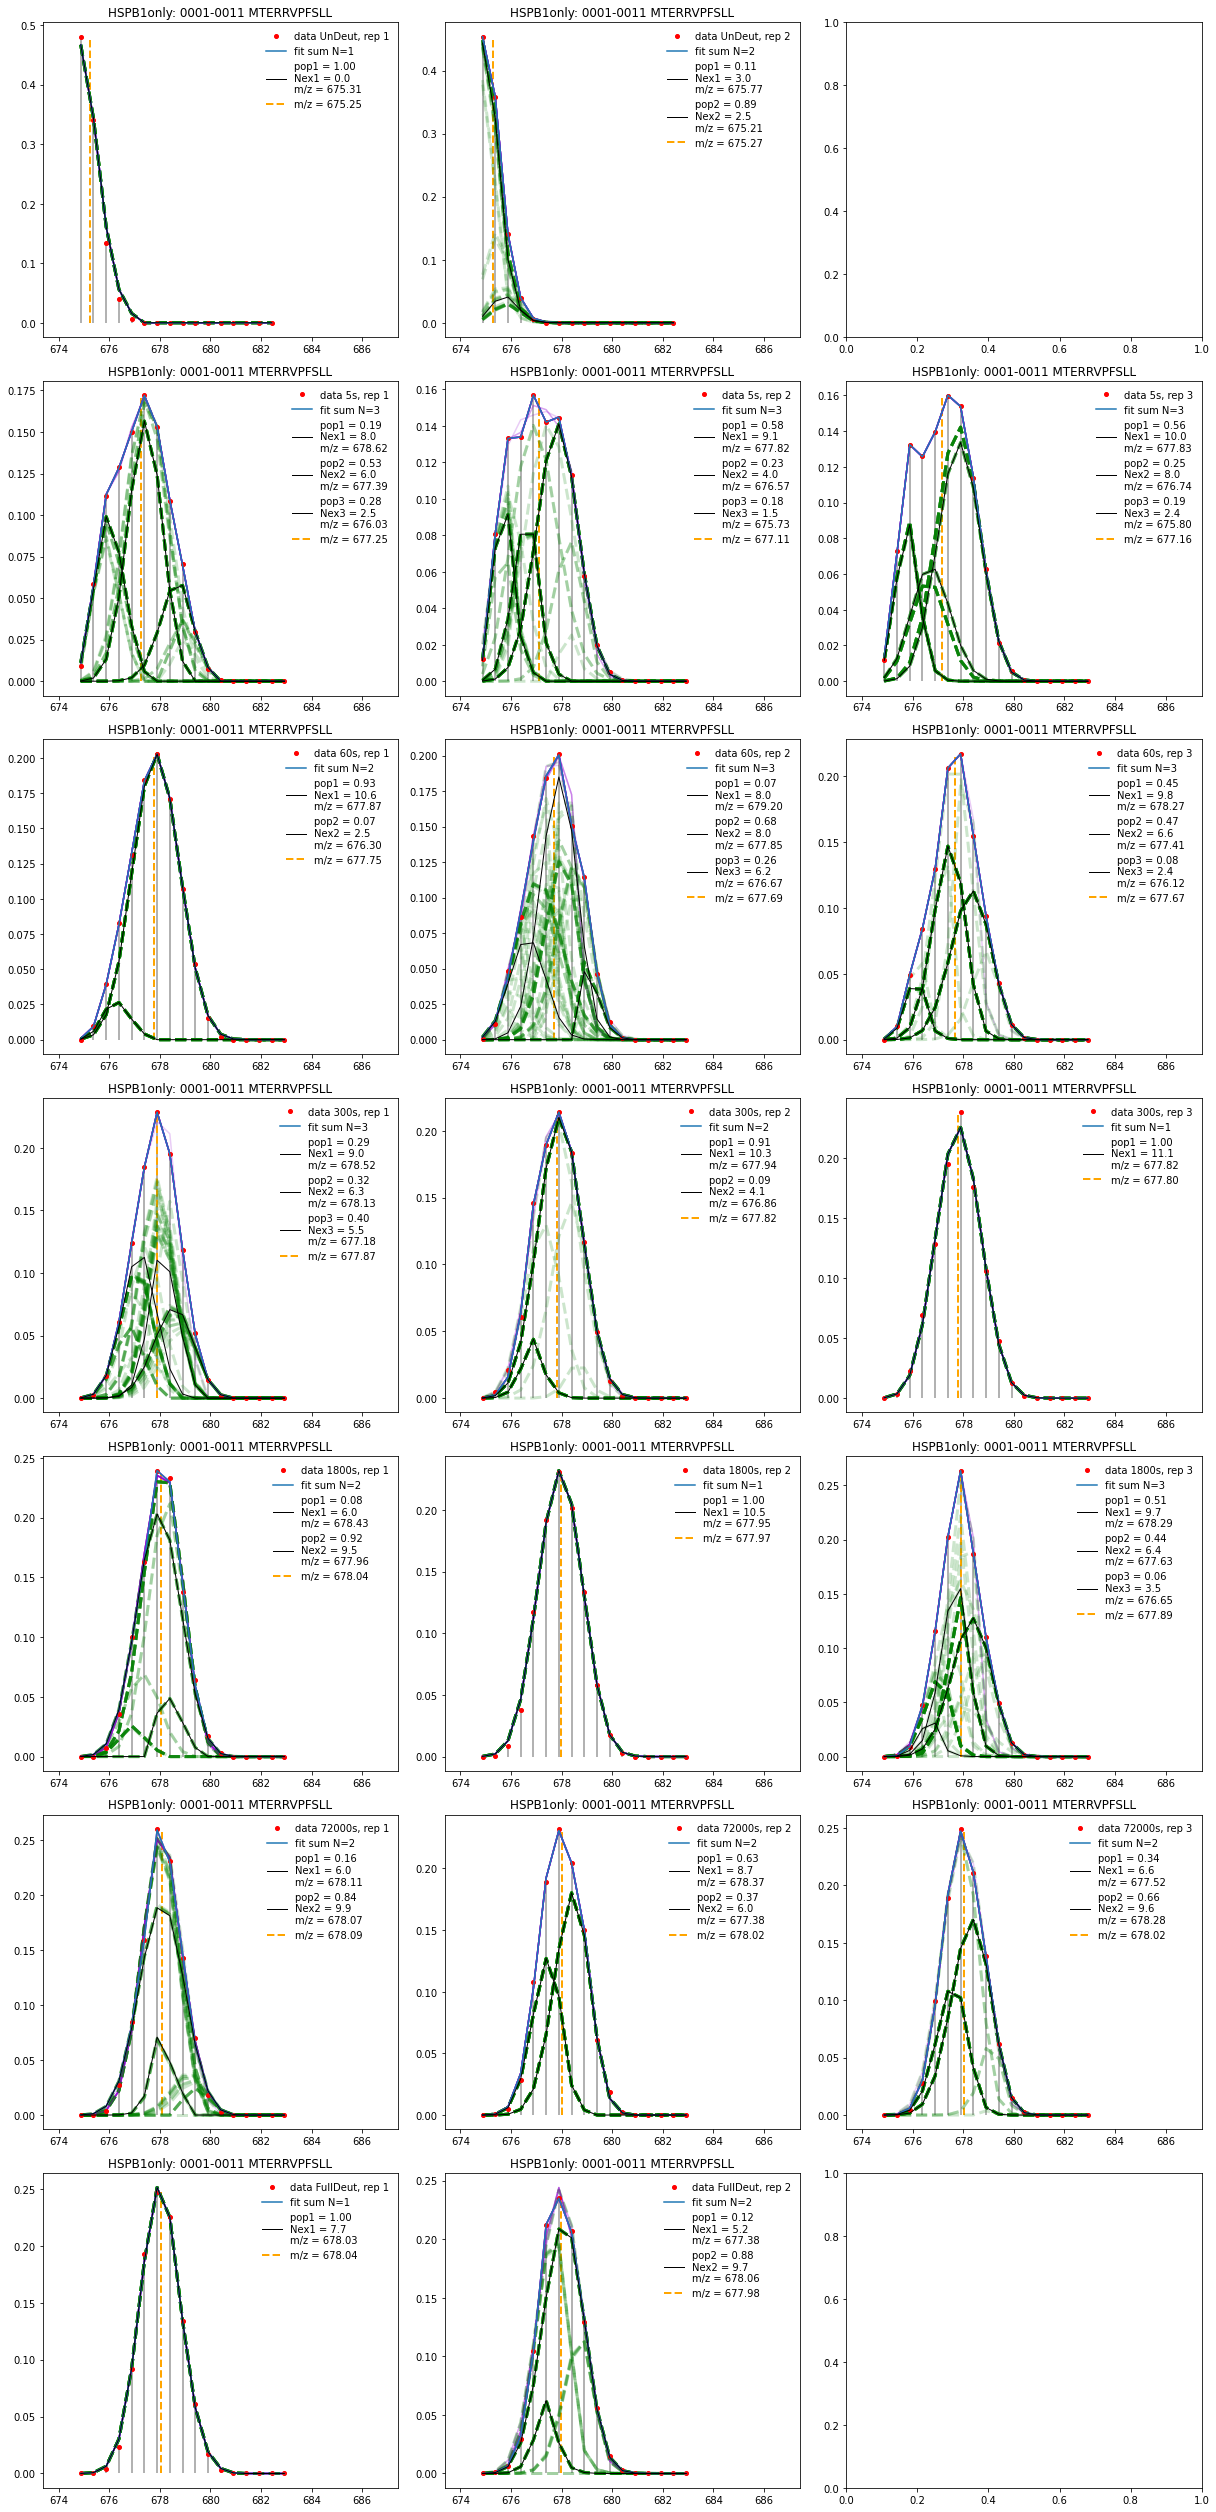

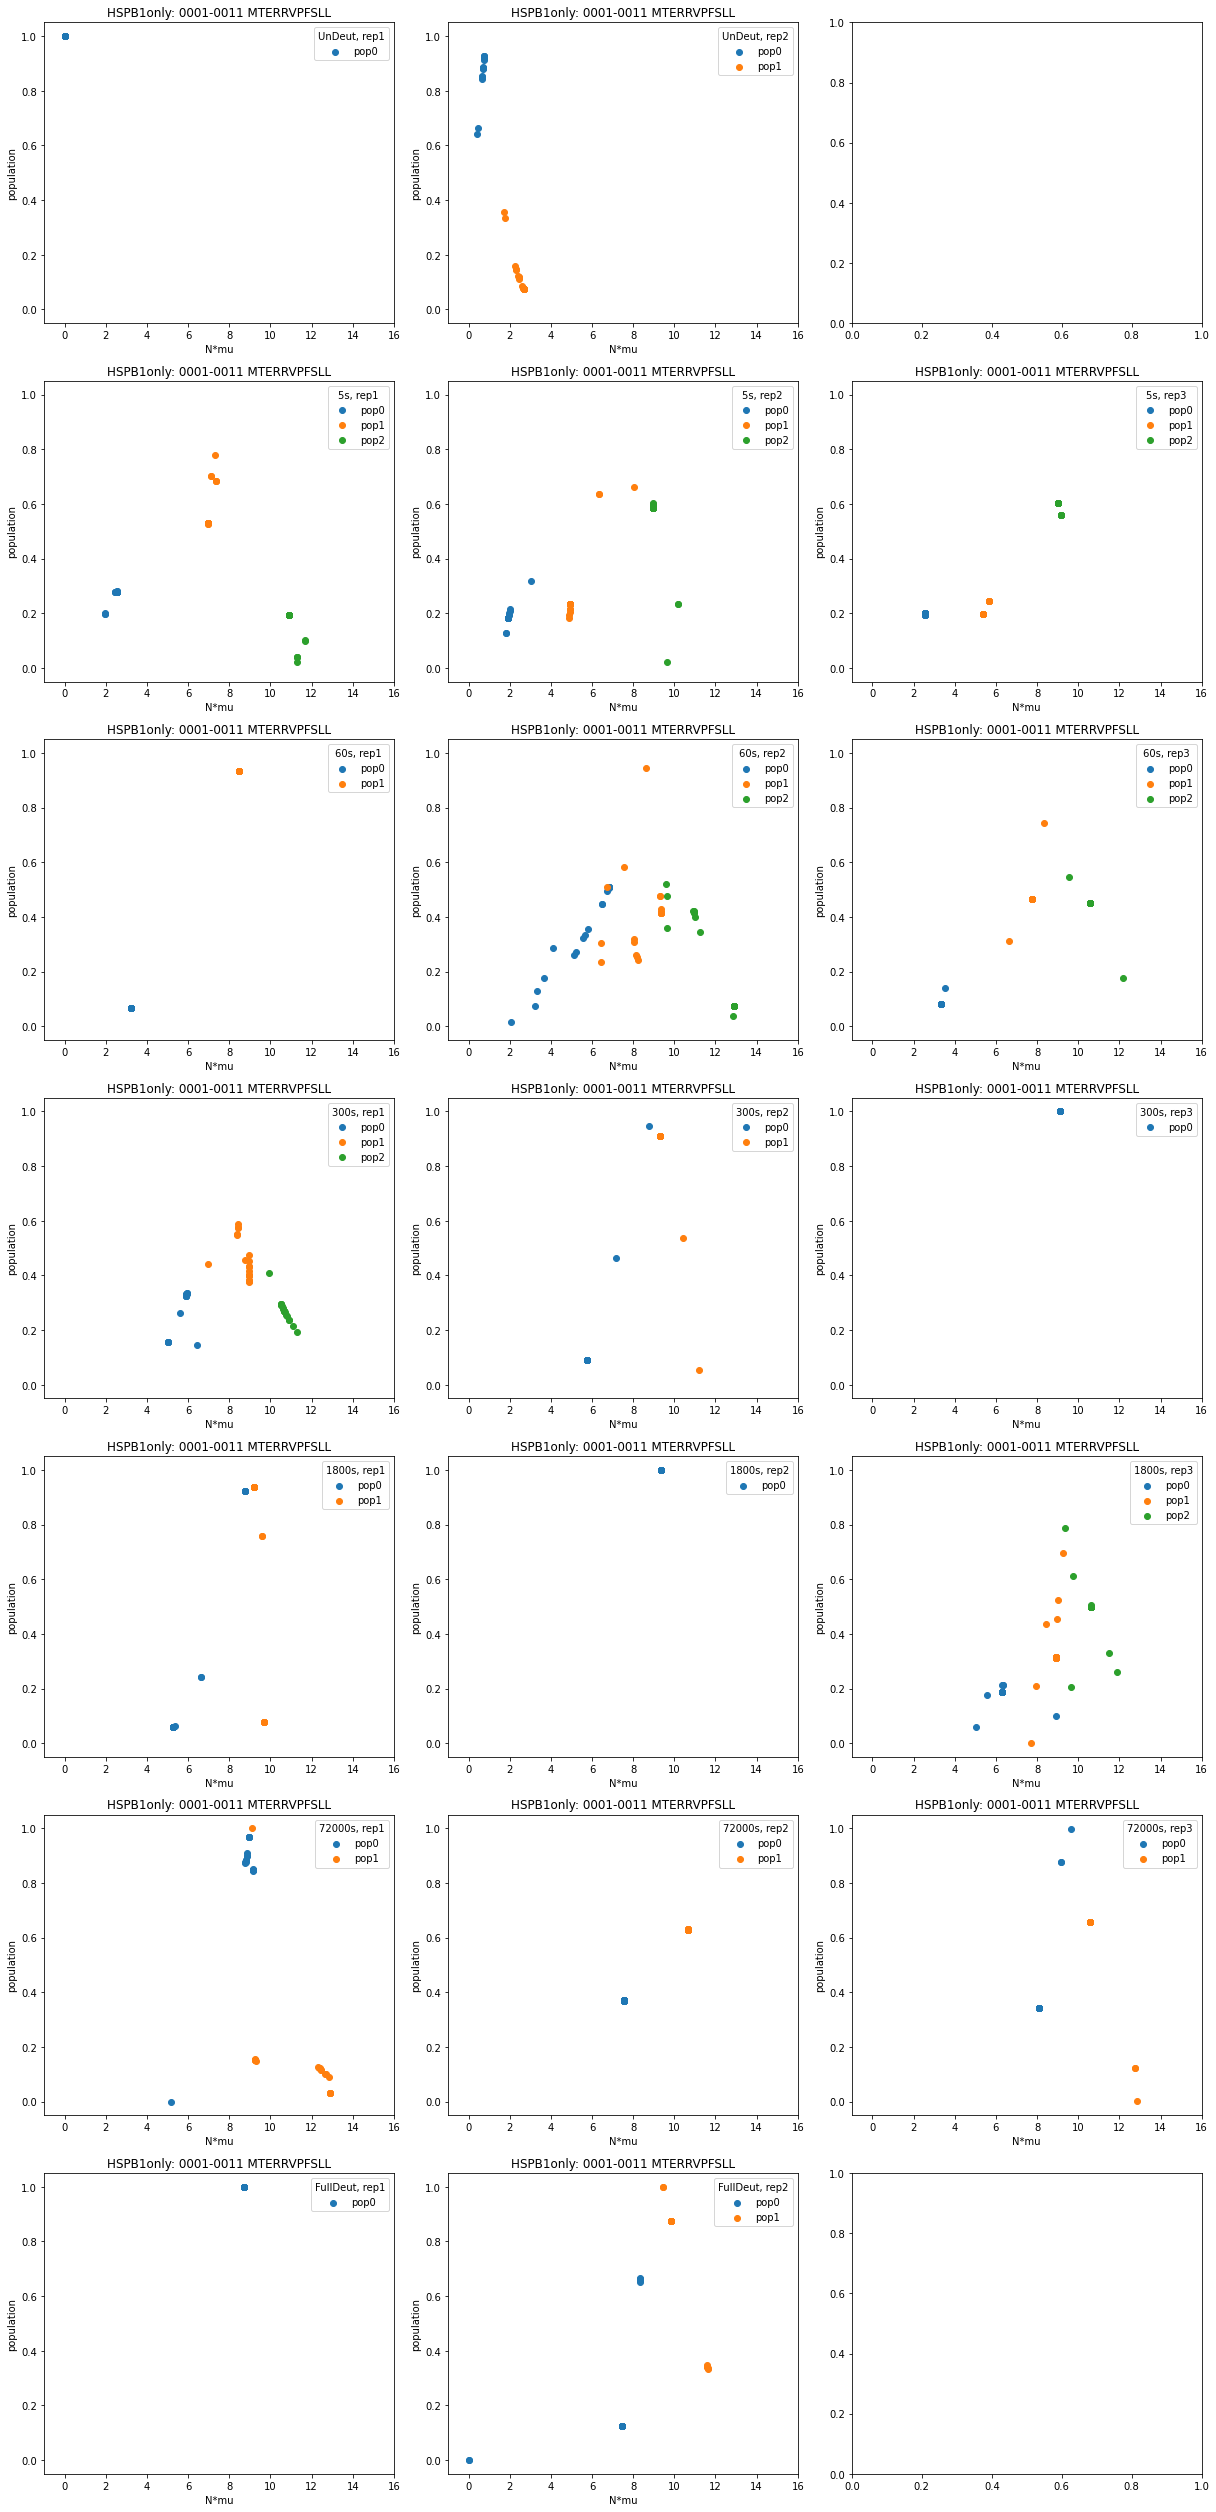

saving figure as  hdx_ms_hxex3_HSPB1only0001-0011binom_isotope_p02_BootFits_NoNoise_26Sep2023


In [6]:
## RUN IT 
### user defined values
data_dir = 'ns_HSPB1_Bimodal_Peptide_Data'

data_type = 1
    #1: 'xlxs' , each file contains all timepoint reps at data_dir/onesample_onepeptide_alltimepts_allreps_onecharge.xlsx
    #2: 'spectexport', as exported from HDExaminer data_dir/samples/peptides/onetimept_onerep_onecharge.csv
    #3: 'csv', test data from MGuttman, e.g Angio & GluFib

hide_figure_output = False
svg = False # also save figures as an svg file, better for making figures 

bootstrap = True #False #
full=True #plot all the bootstrap fits, frac vs nex*mu
cluster=False #perform a kmeans cluster on the nm, frac pairs  #obsolete with nex*mu sorting

nboot = 20 #50 = 1min39, 20 = 1min19s if p0 = best_fit, 50 = 4min9sec with initial_estimate, 20 = 2min54 (with solution plot included)
y_err = 0.0 #random error applied during boot as y*(1+np.random.normal(0,yerr))

pop_thresh = 0.03 #fall back to n-1 curves if population is below this, does not apply to bootstrap fits
ncurve_p_accept = 0.02 #stringency for accepting more fit populations      
random_seed = 16 #used for parameter initialization
boot_seed = True #if False, same seed as random_seed, 
                 #otherwise different seed for each boot iteration (0 to nboot + random_seed + 1 to not repeat initial fit)   


solution = False  #leave this, will get value from read_GuttmanData
#deutdata, solution = read_GuttmanData()

#all_deutdata = read_hexpress_data()

###

now = datetime.now()
date = now.strftime("%d%b%Y")

fout = open(os.path.join(data_dir,'output_v3allfracs_'+date+'.txt'),'w')

## data_type: 1
## in hxexpress format each *.xlsx file contains all m/z vs I for each timepoint and replicates
## samples indicated by initial part of file names
## data_type: 2
## from spectexport, require samples determined from User list and available .fasta files
## 

hx_files = [ f for f in os.listdir(data_dir) if f[-5:]=='.xlsx'  ]
for hdx_sample in [hx_files[0]]:
    deutdata = read_hexpress_data([hdx_sample])
    samples = sorted(set(deutdata["sample"]))
    sample = samples[0]    
    time_points = sorted(set(deutdata.time))
    n_time_points = len(time_points)
    max_time_reps = int(sorted(set(deutdata.rep))[-1])
    peptide = deutdata['peptide'].unique()[0]
    peptide_range = deutdata['peptide_range'].unique()[0]
    charge = deutdata['charge'].unique()[0]
    na_isotope = get_na_isotope(peptide,charge)
    print("Performing fits for "+sample+" "+peptide_range+": "+peptide+" z="+str(int(charge)))
    #print(n_time_points, max_time_reps) 

    fig, ax = plt.subplots(figsize=(max_time_reps*5+2, n_time_points*5), ncols=max_time_reps, nrows = n_time_points)
    if full: fig2, ax2 = plt.subplots(figsize=(max_time_reps*5+2, n_time_points*5), ncols=max_time_reps, nrows = n_time_points)
    #time points are rows i, reps are columns j
    data_fits = pd.DataFrame()
    data_fit = pd.DataFrame()

    n_fitfunc = n_binom_isotope # n_binomials #
    fitfunc = binom_isotope # binom #
    fitfunc_name=str(fitfunc).split()[1]  #fit function as string to add to filenames

    ## get corrected deut values from centroids (not fit data) of Un and FullDeut
    ## Need these to compare to the 'solution' values
    n_amides = count_amides(peptide,count_sc=0.0)
    max_n_amides = count_amides(peptide,count_sc=0.5)
    focal_data = deutdata.copy()[(deutdata.time==0.0) & (deutdata.rep==1)]
    mz=np.array(focal_data.mz.copy())
    y=np.array(focal_data.Intensity.copy())
    centroidUD = sum(mz*y)/sum(y) #undeuterated center

    focal_data = deutdata.copy()[(deutdata.time==1e6) & (deutdata.rep==1)]
    mz=np.array(focal_data.mz.copy())
    y=np.array(focal_data.Intensity.copy())
    centroidTD = sum(mz*y)/sum(y) #total deuteration center
    d_corr = ((centroidTD - centroidUD)/n_amides*charge)

    for i in range(0,n_time_points):
        n_time_rep = int(max(deutdata.rep[(deutdata.time_idx==i)]))
        timept = int(max(deutdata.time[(deutdata.time_idx==i)]))
        if timept == int(1e6): 
            timelabel = 'FullDeut'
        elif timept == 0: timelabel = 'UnDeut'
        else: timelabel = str(timept)+'s'

        ## TODO would like to test n_curves for all reps in time point, then do bootstrap with best_n_curves
        for j in range(1,n_time_rep+1):  
            lowermz = deutdata.mz[deutdata.rep==j].min()
            uppermz = deutdata.mz[deutdata.rep==j].max()

            ## these shouldn't be nested in loop, depend only on peptide
            ## artefact of treating Test data samples as reps
            # n_amides = count_amides(peptide,count_sc=0.0)
            # max_n_amides = count_amides(peptide,count_sc=0.5)
            # nas = int(len(na_isotope)/n_time_rep)
            # Current_Isotope = na_isotope[(j-1)*nas:j*nas]
        
            focal_data = deutdata.copy()[(deutdata.time_idx==i) & (deutdata.rep==j)]
            
            mz=np.array(focal_data.mz.copy())
            y=np.array(focal_data.Intensity.copy())
            x=np.full(y.shape,len(y))

            y_norm = y / np.sum( y )
            n_bins = len(y)-1
            
            max_y = np.max(y) #for parameter initialization

            data_fit =pd.DataFrame({'time':[timept],'rep':[j],'centroid':[sum(mz*y)/sum(y)]})
                    
            fstdev=[]     
            
            p_corr = 1.0 
            low_n = 1
            high_n = 3
            for n_curves in range( low_n, high_n+1 ):  #[scaler] [n *n_curves] [mu *n_curves] [frac * (n_curves )] #-1)]
                initial_estimate, bounds = init_params(n_curves,max_n_amides,max_y,seed=random_seed)
                if (len(initial_estimate) > n_bins): 
                    print(f"attempting to fit more paramaters than data points: time {timelabel} rep {j} N={n_curves} curves")
                    #should be able to exit at this point, haven't updated last fit parameters including p_err
                    break # exit the for n_curves loop

                fit, covar = curve_fit( n_fitfunc, n_bins, y_norm, p0=initial_estimate, maxfev=int(1e6), 
                                        bounds = bounds   )
                fit_y = n_fitfunc( n_bins, *fit )
                if n_curves == low_n: 
                    best_fit = fit 
                    best_covar = covar
                # Perform statistical test, keep the best model
                n_params = len( initial_estimate )
                rss = calc_rss( y_norm, fit_y, )
                if n_curves == low_n: print( timelabel +' '+str(sample) +' N = ' + str(n_curves).ljust(5) + 'p = ' + format( p_corr, '.3e')+str(fit),file=fout)

                if n_curves > low_n:
                    F = ( ( prev_rss - rss ) / 2  ) / ( rss / ( n_bins + 1 - n_params ) )
                    p = 1.0 - stats.f.cdf( F, 2, n_bins + 1 - n_params )
                    p_corr = p * (n_curves-1)
                    print( timelabel +' '+str(sample) +' N = ' + str(n_curves).ljust(5) + 'p = ' + format( p_corr, '.3e')+str(fit),file=fout)
                    if p_corr >= ncurve_p_accept:
                        p_corr = prev_pcorr 
                        break # exit the for n_curves loop; insufficient improvement in fit
                    ## fall back to n-1 curves if one of the populations <  pop_thresh
                    _,_,_,frac_check = get_params(*fit,norm=True,unpack=True)
                    if np.min(frac_check) < pop_thresh:
                        p_corr = prev_pcorr
                        print ("min population below threshold: falling back to",(n_curves-1),"curve(s)")
                        break
                prev_rss = rss   #only gets to these if N is better than N-1           
                prev_pcorr = p_corr
                best_fit = fit            
                best_covar = covar 
                best_n_curves = n_curves    
            #end n_curves for loop

            fit_y = n_fitfunc( n_bins, *best_fit )
            fstdev = np.sqrt(np.diag(best_covar)) ### this error is not realistic
                                                  ### Artifically small: fit can be very well converged but still miss the mark
                                                  ### since measurement contains error and fit is assuming perfect
                                                  ### this is why adding bootstrap noise better samples around 'solution'
                                                  ### Artifically large: essentially swapping between populations during curve_fit
            #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html see pcov
            # To compute one standard deviation errors on the parameters, use perr = np.sqrt(np.diag(pcov)) //when sigma=None

            #print( timelabel +' '+str(samples[j-1]) +' N = ' + str(best_n_curves).ljust(5) + 'p = ' + format( p_corr, '.3e')+str(best_fit),file=fout)

            if bootstrap:            
                p0_boot=[]
                for boot in range(nboot): #send different p0 for each bootstrap iteration
                    if boot_seed: bseed = boot+random_seed+1
                    else: bseed = random_seed
                    p0, bbounds = init_params(best_n_curves,max_n_amides,max_y,seed=bseed)
                    p0_boot.append(p0)
                #p0_boot, bbounds = init_params(best_n_curves,n_amides,max_y,seed=random_seed)
                #rss = 0.0 #calc_rss( y_norm, fit_y, ) #this doesn't seem appropriate for binom fits            
                pfit, perr = fit_bootstrap(p0_boot,bbounds,n_bins,y_norm,n_fitfunc,sigma_res=0.0,yerr_systematic=y_err, nboot=nboot,ax=ax[i,j-1],full=full)
                #pfit = get_params(*pfit,sort=False,norm=True,unpack=False)
                
                # plot mus vs fracs for each dataset if full=True
                if full:
                    p_array=np.array(pfit)
                    ns_array = p_array[:,1:best_n_curves+1]
                    mus_array = p_array[:,best_n_curves+1:best_n_curves*2+1]                
                    fracs_array = p_array[:,-best_n_curves:]
                    
                    if cluster:
                        n_all = ns_array.flatten(order='F')
                        mu_all = mus_array.flatten(order='F')
                        nm_all = n_all * mu_all  #trying to cluster according to fracs, Nex * mu
                        f_all = fracs_array.flatten(order='F')
                        m_f = [ [u,v] for u,v in zip(mu_all,f_all)]
                        nm_f = [[u,v] for u,v in zip(nm_all,f_all)]
                        boot_pairs = nm_f #m_f
                        kmeans = KMeans(n_clusters=best_n_curves,random_state=0,n_init="auto").fit_predict(boot_pairs)
                        #colors=['black','red','cyan']
                        markers=['_','|','x']
                        sc = ax2[i,j-1].scatter(nm_all,f_all,c=kmeans,cmap='tab10',marker='s',s=50,alpha=0.5) #mu_all
                        ax2[i,j-1].legend(*sc.legend_elements(),title='clusters for '+ timelabel,frameon=False,loc='upper right')
                    else:
                        for n in range(best_n_curves):
                            nm = mus_array[:,n]*ns_array[:,n]*1/d_corr #apply correction based on TD-UN
                            #ax2[i,j-1].scatter(fracs_array[:,n],mus_array[:,n],label='pop'+str(n))
                            ax2[i,j-1].scatter(nm,fracs_array[:,n],label='pop'+str(n))
                    if solution:
                        for k in range(3):
                            s_nm = solution['fd'+str(k+1)][solution.time==timept].to_numpy()[0]/100*n_amides #this is #D uncorrected
                            s_f = solution['p'+str(k+1)][solution.time==timept].to_numpy()[0]
                            ax2[i,j-1].scatter(s_nm,s_f,edgecolors='darkred',alpha=1.0,marker='o',facecolor='none',s=60,linewidth=1.5)#label='Solution'+str(k+1),


            ### PLOTS ###
            ax[i,j-1].vlines( mz, 0.0, y_norm, color='#999999' ) #ax[i,j-1].
            ax[i,j-1].plot( mz, y_norm, 'ro', label='data '+ timelabel+", rep "+str(j), markersize='4')
            ax[i,j-1].vlines( data_fit.centroid[0], 0, max(y_norm), color='orange' ,label='m/z = '+format(data_fit.centroid[0],'.2f'),linestyles='dashed',linewidth=2)

            
            ax[i,j-1].plot( mz, fit_y, '-', label='fit sum N='+str(best_n_curves))
            # if bootstrap:
            #     boot_y = n_fitfunc(n_bins, *pfit)
            #     ax[i,j-1].plot( mz, boot_y, color = 'purple', linestyle='solid', label='bfit sum N='+str(best_n_curves),zorder=10)

            scaler,nexs,mus,fracs = get_params(*best_fit,sort=False,norm=False,unpack=True)
            scaler = np.power( 10.0, scaler )   
            fracsum = np.sum(fracs)

            #scaler at 0, n's at 1:best_n_curves+1, mu's at best_n_curves+1:2*best_ncurves+1, fracs at 2*best_n_curves+1:
            for k in range( best_n_curves ):
                nex = nexs[k]
                nex_err = fstdev[k+1]
                mu = mus[k]
                mu_err = fstdev[k+best_n_curves+1]
                frac = fracs[k]/fracsum
                frac_err = min(1.0,fstdev[-1]/fracsum) #if best_n_curves > 1 else 0.
                fit_yk = scaler * frac * fitfunc( n_bins, nex, mu, )
                kindcent = sum(mz*fit_yk)/sum(fit_yk)
                data_fit['icentroid_'+str(k+1)]=kindcent
                data_fit['ipop_'+str(k+1)]=frac
                data_fit['ipop_std_'+str(k+1)]=frac_err
                data_fit['imu_'+str(k+1)]=mu
                data_fit['iNex_'+str(k+1)]=nex
                data_fit['iNex_std_'+str(k+1)]=nex_err
                #leaving off errors until I can account for populations swapping during fit
                #maybe if fixed mu1 < mu2 or somesuch 
                plot_label = ('pop'+str(k+1)+' = '+format(frac,'.2f')#+' ± '+format(frac_err,'.2f') 
                                    +'\nNex'+str(k+1)+' = '+format(nex,'.1f')#+' ± '+format(nex_err,'.2f')
                                    +'\nm/z = '+format(kindcent,'.2f'))
                ax[i,j-1].plot( mz, fit_yk, color = 'black', linestyle='solid',linewidth=1.,label=plot_label)
                ax[i,j-1].set(xlim=(lowermz-3/charge,uppermz+9/charge)) #gives rightside space for legend
            ax[i,j-1].set_title(label=str(sample)+': '+peptide_range+" "+str(peptide),loc='center')
            ax[i,j-1].legend(frameon=False,loc='upper right');
            data_fit['iscaler']=scaler
            data_fits = data_fits.append(data_fit, ignore_index=True)
            if full:
                ax2[i,j-1].set_title(label=str(sample)+': '+peptide_range+" "+str(peptide),loc='center')
                if ~cluster: ax2[i,j-1].legend(title=timelabel+", rep"+str(j),frameon=True,loc='upper right');
                ax2[i,j-1].set(xlim=(-1.,max_n_amides+4),ylim=(-0.05,1.05))
                ax2[i,j-1].set_xlabel("N*mu")
                ax2[i,j-1].set_ylabel("population") 
    fig.tight_layout()
    if full: fig2.tight_layout()
    #fig.savefig('hdx_ms_analysis_binomials_grid.png',dpi=600)

    if bootstrap: 
        if y_err: yerr_name = 'bootNoise0p'+format(y_err,'.2f')[-2:]+'_'
        else: yerr_name = 'NoNoise_'
    else: yerr_name = ''
    try:
        figfile = 'hdx_ms_hxex3_'+sample+peptide_range+fitfunc_name+'_p'+format(int(ncurve_p_accept*100),'02d')+'_IndFits_'+yerr_name+date
        print("saving figure as ",figfile)
        fig.savefig(os.path.join(data_dir,figfile+'.pdf'),format='pdf',dpi=600)
        if svg: fig.savefig(os.path.join(data_dir,figfile+'.svg'),format='svg')
        if hide_figure_output: plt.close(fig)
        else: plt.show()
    except IOError as e:
        print (f"Could not save: {figfile} file is open")   


    try:
        fig2file = 'hdx_ms_hxex3_'+sample+peptide_range+fitfunc_name+'_p'+format(int(ncurve_p_accept*100),'02d')+'_BootFits_'+yerr_name+date
        print("saving figure as ",fig2file)
        fig2.savefig(os.path.join(data_dir,fig2file+'.pdf'),format='pdf',dpi=600)
        if svg: fig2.savefig(os.path.join(data_dir,fig2file+'.svg'),format='svg')
        if hide_figure_output: plt.close(fig2)
        else: plt.show()
    except IOError as e:
        print (f"Could not save: {fig2file} file is open") 

fout.close()


In [78]:
# #fig.savefig('hdx_ms_analysis_binomials_grid_GuttmanData_13mar2023.png',dpi=600)
# #fig.savefig('hdx_ms_analysis_floatNex_binomIsotope_23mar2023.pdf',format='pdf',dpi=600)
# if bootstrap: 
#     if y_err: yerr_name = 'bootNoise0p'+format(y_err,'.2f')[-2:]+'_'
#     else: yerr_name = 'NoNoise_'
# else: yerr_name = ''
# try:
#     figfile = 'hdx_ms_hxex3_'+fitfunc_name+'_p'+format(int(ncurve_p_accept*100),'02d')+'_IndFits_'+yerr_name+date+'_allfracs'
#     print("saving figure as ",figfile)
#     fig.savefig(os.path.join(data_dir,figfile+'.pdf'),format='pdf',dpi=600)
#     if svg: fig.savefig(os.path.join(data_dir,figfile+'.svg'),format='svg')
#     #if hide_figure_output: plt.close(fig)
# except IOError as e:
#     print (f"Could not save: {figfile} file is open")   


# try:
#     fig2file = 'hdx_ms_hxex3_'+fitfunc_name+'_p'+format(int(ncurve_p_accept*100),'02d')+'_BootFits_'+yerr_name+date+'_allfracs'
#     print("saving figure as ",fig2file)
#     fig2.savefig(os.path.join(data_dir,fig2file+'.pdf'),format='pdf',dpi=600)
#     if svg: fig2.savefig(os.path.join(data_dir,fig2file+'.svg'),format='svg')
#     #if hide_figure_output: plt.close(fig2)
# except IOError as e:
#     print (f"Could not save: {fig2file} file is open") 

In [79]:
# ## Plot Fraction Deuterated ##
# hide_figure_output=False

# if solution:
#     file=os.path.join(data_dir, "bimodal_solutions.txt")
#     solution = pd.read_csv(file,delim_whitespace=True,)
#     solution = solution.sort_values('time').reset_index()

# for j in range(max_time_reps):
#     mutant = samples[j]
#     peptide = peptides[j]
#     charge = charges[j]
#     rep_data = data_fits.copy()[data_fits.rep ==j+1].reset_index()
#     unmass = rep_data[rep_data['time']==0]['centroid'].mean()
#     fullmass = rep_data[rep_data['time']==1e6]['centroid'].mean()
#     dfig,dax=plt.subplots(figsize=(18,6))
#     rep_data['frac_deut']=(rep_data['centroid']-unmass)/(fullmass-unmass)

#     icolors=['red','lightblue','b']
#     iecolors=['k','k','k']

#     if solution:
#         for i in range(4):
#             if 'icentroid_'+str(i+1) in rep_data.columns:
#                 rep_data['i'+str(i+1)+'_frac_deut']=(rep_data['icentroid_'+str(i+1)]-unmass)/(fullmass-unmass)
#                 dax.scatter(solution.index+1,rep_data['i'+str(i+1)+'_frac_deut'],marker='v',label='Ind_fit'+str(i+1),edgecolors=iecolors[i],lw=0.4,c='red',s=rep_data['ipop_'+str(i+1)]*150+20)
#                 dax.scatter(solution.index+1,0.01*solution['fd'+str(i+1)],label='Solution'+str(i+1),edgecolors='k',alpha=1.0,marker='o',facecolor='none',s=solution['p'+str(i+1)]*150+20)
#     #dax.scatter(rep_data.index,rep_data['frac_deut'],marker='.',label='Centroid',c='silver',edgecolors='k')
    
#     dax.hlines(xmin=[0,0,0,0,0],xmax=[48,48,48,48,48],y=[0.0,0.25, 0.5, 0.75,1.0],alpha=0.5,linestyles='dotted',color='grey')
#     #dax.set_xscale('log')
#     dax.set(xlim=(0,24),ylim=(-0.1,1.1))
#     dax.legend(frameon=True,loc='upper left')#, bbox_to_anchor=(1.01,1.0))
#     dax.set_title('Fraction Deuterated:'+mutant+' '+peptide+' z='+str(charge));
#     dax.set_xlabel('Experiment');
#     dax.set_ylabel('frac deut');

#     try:
#         figfile = 'hdx_ms_'+str(mutant)+'_'+fitfunc_name+'_p'+format(int(ncurve_p_accept*100),'02d')+'_fracDeut_allfracs'
#         print("saving figure as ",figfile)
#         dfig.savefig(os.path.join(data_dir,figfile+'.pdf'),format='pdf',dpi=600)
#         if svg: dfig.savefig(os.path.join(data_dir,figfile+'.svg'),format='svg')
#         if hide_figure_output: plt.close(dfig)
#     except IOError as e:
#         print (f"Could not save: {figfile} file is open")           
    
#     try:
#         datafile = 'data_fits_'+str(mutant)+'_'+fitfunc_name+'_p'+format(int(ncurve_p_accept*100),'02d')+'_allfracs.tsv'
#         print("saving fit data as "+datafile)
#         rep_data.to_csv(os.path.join(data_dir,datafile),sep="\t")
#     except IOError as e:
#         print (f"Could not save: {datafile} file is open")

In [80]:
# import matplotlib.pyplot as plt
# peptide=peptides[0]
# na_isotope=[]
# pepcomp = {}
# if goodseq(peptide): comp = mass.Composition(peptide) 
# else: comp = {}
# for key in list(comp):
#     pepcomp[key] = comp[key]
# pepcomp['H'] = pepcomp['H']-count_amides(peptide,count_sc=0.0)
# #pepcomp = {'H': 53, 'C': 34, 'O': 15, 'N': 7}
# theoretical_isotopic_cluster = isotopic_variants(pepcomp, npeaks=10, charge=charge)

# for ipeak in theoretical_isotopic_cluster:
#     na_isotope = np.append(na_isotope, ipeak.intensity) #for now just make continuous list for all peptides
#                                                         #won't make sense to do this for full version
# print(na_isotope)

# compare_naiso = [0.6927,        0.2202,        0.0678,        0.0162,        0.0031]
# plt.vlines(np.arange(len(compare_naiso)),np.zeros(len(compare_naiso)),compare_naiso)

# plt.vlines(np.arange(len(na_isotope))+.1,np.zeros(len(na_isotope)),na_isotope,color='red')

# print(np.sum(na_isotope))
# print(np.sum(compare_naiso))


In [81]:
# d_corr=[]
# for j in range(1,rep): #assumes all reps have UN and TD 
#     n_amides = count_amides(peptides[j-1],count_sc=0.0)
#     focal_data = deutdata.copy()[(deutdata.time==0.0) & (deutdata.rep==j)]
#     mz=np.array(focal_data.mz.copy())
#     y=np.array(focal_data.Intensity.copy())
#     centroidUD = sum(mz*y)/sum(y) #undeuterated center

#     focal_data = deutdata.copy()[(deutdata.time==1e6) & (deutdata.rep==j)]
#     mz=np.array(focal_data.mz.copy())
#     y=np.array(focal_data.Intensity.copy())
#     centroidTD = sum(mz*y)/sum(y) #total deuteration center
#     d_corr.append((centroidTD - centroidUD)/n_amides*charges[j-1])

# print(d_corr)

In [82]:
# x = "undeut2"
# x[0:6]